In [1]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils

In [2]:
def color_grayscale_arr(arr, red=True):
  """Converts grayscale image to either red or green"""
  assert arr.ndim == 2
  dtype = arr.dtype
  h, w = arr.shape
  arr = np.reshape(arr, [h, w, 1])
  if red:
    arr = np.concatenate([arr,
                          np.zeros((h, w, 2), dtype=dtype)], axis=2)
  else:
    arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                          arr,
                          np.zeros((h, w, 1), dtype=dtype)], axis=2)
  return arr


class ColoredMNIST(datasets.VisionDataset):
  """
  Colored MNIST dataset for testing IRM. Prepared using procedure from https://arxiv.org/pdf/1907.02893.pdf

  Args:
    root (string): Root directory of dataset where ``ColoredMNIST/*.pt`` will exist.
    env (string): Which environment to load. Must be 1 of 'train1', 'train2', 'test', or 'all_train'.
    transform (callable, optional): A function/transform that  takes in an PIL image
      and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
      target and transforms it.
  """
  def __init__(self, root='./data', env='train1', transform=None, target_transform=None):
    super(ColoredMNIST, self).__init__(root, transform=transform,
                                target_transform=target_transform)

    self.prepare_colored_mnist()
    if env in ['train1', 'train2', 'test']:
      self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')
    elif env == 'all_train':
      self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', 'train1.pt')) + \
                               torch.load(os.path.join(self.root, 'ColoredMNIST', 'train2.pt'))
    else:
      raise RuntimeError(f'{env} env unknown. Valid envs are train1, train2, test, and all_train')

  def __getitem__(self, index):
    """
    Args:
        index (int): Index

    Returns:
        tuple: (image, target) where target is index of the target class.
    """
    img, target, grp_idx = self.data_label_tuples[index]

    if self.transform is not None:
      img = self.transform(img)

    if self.target_transform is not None:
      target = self.target_transform(target)

    return img, target, grp_idx

  def __len__(self):
    return len(self.data_label_tuples)

  def prepare_colored_mnist(self):
    colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
    if os.path.exists(os.path.join(colored_mnist_dir, 'train1.pt')) \
        and os.path.exists(os.path.join(colored_mnist_dir, 'train2.pt')) \
        and os.path.exists(os.path.join(colored_mnist_dir, 'test.pt')):
      print('Colored MNIST dataset already exists')
      return

    print('Preparing Colored MNIST')
    train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)

    train1_set = []
    train2_set = []
    n_groups = 4
    test_set = []
    for idx, (im, label) in enumerate(train_mnist):
      if idx % 10000 == 0:
        print(f'Converting image {idx}/{len(train_mnist)}')
      im_array = np.array(im)

      # Assign a binary label y to the image based on the digit
      binary_label = 0 if label < 5 else 1

      # Flip label with 25% probability
      if np.random.uniform() < 0.25:
        binary_label = binary_label ^ 1

      # Color the image either red or green according to its possibly flipped label
      color_red = binary_label == 0

      # Flip the color with a probability e that depends on the environment
      if idx < 20000:
        # 20% in the first training environment
        if np.random.uniform() < 0.2:
          color_red = not color_red
      elif idx < 40000:
        # 10% in the first training environment
        if np.random.uniform() < 0.1:
          color_red = not color_red
      else:
        # 90% in the test environment
        if np.random.uniform() < 0.9:
          color_red = not color_red

      colored_arr = color_grayscale_arr(im_array, red=color_red)
      group_idx = int(binary_label * (2) + color_red)


      if idx < 20000:
        train1_set.append((Image.fromarray(colored_arr), binary_label, group_idx))
      elif idx < 40000:
        train2_set.append((Image.fromarray(colored_arr), binary_label, group_idx))
      else:
        test_set.append((Image.fromarray(colored_arr), binary_label, group_idx))

      # Debug
      # print('original label', type(label), label)
      # print('binary label', binary_label)
      # print('assigned color', 'red' if color_red else 'green')
      # plt.imshow(colored_arr)
      # plt.show()
      # break

    #dataset_utils.makedir_exist_ok(colored_mnist_dir)
    if not os.path.exists(colored_mnist_dir):
      os.makedirs(colored_mnist_dir)
    torch.save(train1_set, os.path.join(colored_mnist_dir, 'train1.pt'))
    torch.save(train2_set, os.path.join(colored_mnist_dir, 'train2.pt'))
    torch.save(test_set, os.path.join(colored_mnist_dir, 'test.pt'))

In [3]:
def plot_dataset_digits(dataset):
  fig = plt.figure(figsize=(13, 8))
  columns = 6
  rows = 3
  # ax enables access to manipulate each of subplots
  ax = []

  for i in range(columns * rows):
    img, label, grp_idx = dataset[i]
    # create subplot and append to ax
    ax.append(fig.add_subplot(rows, columns, i + 1))
    ax[-1].set_title("Label: " + str(label))  # set title
    plt.imshow(img)

  plt.show()  # finally, render the plot
  


Preparing Colored MNIST


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Converting image 0/60000
Converting image 10000/60000
Converting image 20000/60000
Converting image 30000/60000
Converting image 40000/60000
Converting image 50000/60000


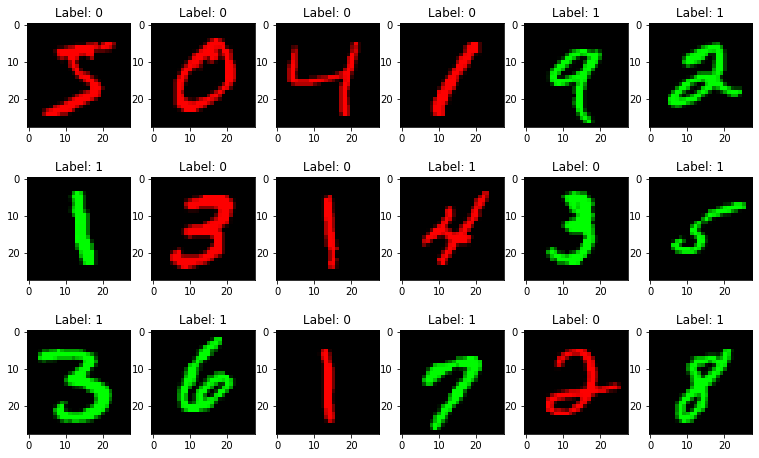

In [4]:
train1_set = ColoredMNIST(root='./data', env='train1')
plot_dataset_digits(train1_set)

In [5]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(3 * 28 * 28, 512)
    self.fc2 = nn.Linear(512, 512)
    self.fc3 = nn.Linear(512, 1)

  def forward(self, x):
    x = x.view(-1, 3 * 28 * 28)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    logits = self.fc3(x).flatten()
    return logits


class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4 * 4 * 50, 500)
    self.fc2 = nn.Linear(500, 1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4 * 4 * 50)
    x = F.relu(self.fc1(x))
    logits = self.fc2(x).flatten()
    return logits

In [6]:
def test_model(model, device, test_loader, set_name="test set"):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target, _ in test_loader:
      data, target = data.to(device), target.to(device).float()
      output = model(data)
      test_loss += F.binary_cross_entropy_with_logits(output, target, reduction='sum').item()  # sum up batch loss
      pred = torch.where(torch.gt(output, torch.Tensor([0.0]).to(device)),
                         torch.Tensor([1.0]).to(device),
                         torch.Tensor([0.0]).to(device))  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)

  print('\nPerformance on {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    set_name, test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

  return 100. * correct / len(test_loader.dataset)


def erm_train(model, device, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, (data, target, _) in enumerate(train_loader):
    data, target = data.to(device), target.to(device).float()
    optimizer.zero_grad()
    output = model(data)
    loss = F.binary_cross_entropy_with_logits(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
               100. * batch_idx / len(train_loader), loss.item()))


def train_and_test_erm():
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
  all_train_loader = torch.utils.data.DataLoader(
    ColoredMNIST(root='./data', env='all_train',
                 transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
                   ])),
    batch_size=64, shuffle=True, **kwargs)

  test_loader = torch.utils.data.DataLoader(
    ColoredMNIST(root='./data', env='test', transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
    ])),
    batch_size=1000, shuffle=True, **kwargs)

  model = ConvNet().to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.01)

  for epoch in range(1, 2):
    erm_train(model, device, all_train_loader, optimizer, epoch)
    test_model(model, device, all_train_loader, set_name='train set')
    test_model(model, device, test_loader)

train_and_test_erm()

Colored MNIST dataset already exists
Colored MNIST dataset already exists
Train Epoch: 1 [0/40000 (0%)]	Loss: 0.702667
Train Epoch: 1 [640/40000 (2%)]	Loss: 0.613315
Train Epoch: 1 [1280/40000 (3%)]	Loss: 0.650247
Train Epoch: 1 [1920/40000 (5%)]	Loss: 0.399213
Train Epoch: 1 [2560/40000 (6%)]	Loss: 0.502113
Train Epoch: 1 [3200/40000 (8%)]	Loss: 0.422928
Train Epoch: 1 [3840/40000 (10%)]	Loss: 0.410855
Train Epoch: 1 [4480/40000 (11%)]	Loss: 0.471492
Train Epoch: 1 [5120/40000 (13%)]	Loss: 0.342222
Train Epoch: 1 [5760/40000 (14%)]	Loss: 0.463517
Train Epoch: 1 [6400/40000 (16%)]	Loss: 0.559064
Train Epoch: 1 [7040/40000 (18%)]	Loss: 0.359981
Train Epoch: 1 [7680/40000 (19%)]	Loss: 0.367092
Train Epoch: 1 [8320/40000 (21%)]	Loss: 0.470627
Train Epoch: 1 [8960/40000 (22%)]	Loss: 0.363969
Train Epoch: 1 [9600/40000 (24%)]	Loss: 0.365366
Train Epoch: 1 [10240/40000 (26%)]	Loss: 0.320688
Train Epoch: 1 [10880/40000 (27%)]	Loss: 0.416320
Train Epoch: 1 [11520/40000 (29%)]	Loss: 0.530647
Tr

In [48]:
from torch.utils.data import dataloader
def calculate_avg_group_loss(y_hat, y, group_idx, criterion):

  losses = F.binary_cross_entropy_with_logits(y_hat, y, reduction='none')
  group_map = (group_idx == torch.arange(4).unsqueeze(1).long().cuda()).float()
  group_count = group_map.sum(1)
  group_denom = group_count + (group_count==0).float()
  group_loss = (group_map @ losses.view(-1)).T/group_denom

  return group_loss

def group_dro_train(model, device, train_loaders, optimizer, epoch, criterion, adjustment, adv_probs, step_size):
  model.train()

  train_loaders = [iter(x) for x in train_loaders]


  batch_idx = 0
  optimizer.zero_grad()
  error = 0

  for loader in train_loaders:
    for batch_idx, (data, target, grp_idx) in enumerate(loader):
      data, target, grp_idx = data.to(device), target.to(device).float(), grp_idx.to(device)
      output = model(data)
      loss_group =  calculate_avg_group_loss(output, target, grp_idx, criterion)
      adjusted_loss = loss_group
      if torch.all(adjustment > 0):
        adjusted_loss += adjustment / torch.sqrt(4)
      adv_probs = adv_probs * torch.exp(step_size * adjusted_loss.data)
      adv_probs = adv_probs / (adv_probs.sum())
      robust_loss = loss_group @ adv_probs

      optimizer.zero_grad()
      robust_loss.backward()
      optimizer.step()

      if batch_idx % 2 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tRobust loss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loaders[0]),
               100. * batch_idx / len(train_loaders[0]), robust_loss.item()))
      #print('First 20 logits', output.data.cpu().numpy()[:20])

  return adv_probs



def train_and_test_irm():
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
  train1_loader = torch.utils.data.DataLoader(
    ColoredMNIST(root='./data', env='train1',
                 transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
                   ])),
    batch_size=2000, shuffle=True, **kwargs)

  train2_loader = torch.utils.data.DataLoader(
    ColoredMNIST(root='./data', env='train2',
                 transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
                   ])),
    batch_size=2000, shuffle=True, **kwargs)

  test_loader = torch.utils.data.DataLoader(
    ColoredMNIST(root='./data', env='test', transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
    ])),
    batch_size=1000, shuffle=True, **kwargs)

  model = ConvNet().to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  alpha = 0.2
  gamma = 0.1
  #criterion = torch.nn.CrossEntropyLoss(reduce=False, reduction = 'none')
  #criterion = torch.nn.CrossEntropyLoss()
  #criterion = F.binary_cross_entropy_with_logits(reduction='none')
  criterion = None
  adjustment = torch.from_numpy(np.array([0.0] * 4)).float().cuda()
  robust_step_size = 0.01
  adv_probs = torch.ones(4).cuda()/4

  for epoch in range(1, 100):
    adv_probs = group_dro_train(model, device, [train1_loader, train2_loader], optimizer, epoch, criterion, adjustment, adv_probs, robust_step_size)
    train1_acc = test_model(model, device, train1_loader, set_name='train1 set')
    train2_acc = test_model(model, device, train2_loader, set_name='train2 set')
    test_acc = test_model(model, device, test_loader)
    if train1_acc > 75 and train2_acc > 75 and test_acc > 70:
      print('found acceptable values. stopping training.')
      return


In [49]:
train_and_test_irm()

Colored MNIST dataset already exists
Colored MNIST dataset already exists
Colored MNIST dataset already exists
Train Epoch: 1 [0/10 (0%)]	Robust loss: 0.693665
Train Epoch: 1 [4000/10 (20%)]	Robust loss: 0.705047
Train Epoch: 1 [8000/10 (40%)]	Robust loss: 0.679553
Train Epoch: 1 [12000/10 (60%)]	Robust loss: 0.680485
Train Epoch: 1 [16000/10 (80%)]	Robust loss: 0.667523
Train Epoch: 1 [0/10 (0%)]	Robust loss: 0.643218
Train Epoch: 1 [4000/10 (20%)]	Robust loss: 0.659282
Train Epoch: 1 [8000/10 (40%)]	Robust loss: 0.638367
Train Epoch: 1 [12000/10 (60%)]	Robust loss: 0.629398
Train Epoch: 1 [16000/10 (80%)]	Robust loss: 0.617116

Performance on train1 set: Average loss: 0.6290, Accuracy: 13636/20000 (68.18%)


Performance on train2 set: Average loss: 0.6231, Accuracy: 13774/20000 (68.87%)


Performance on test set: Average loss: 0.6041, Accuracy: 13895/20000 (69.47%)

Train Epoch: 2 [0/10 (0%)]	Robust loss: 0.634307
Train Epoch: 2 [4000/10 (20%)]	Robust loss: 0.611709
Train Epoch: 2 [8

KeyboardInterrupt: ignored